# House Price Prediction Using Random Forest

## Data Preprocessing and Feature Engineering

1. **Drop Unnecessary Columns**:
   - Removed irrelevant columns to simplify the dataset.
   - Converted `statezip` to an integer for better processing.

2. **Handle Missing Values**:
   - Dropped rows with missing values to ensure data quality.

3. **Feature Engineering**:
   - Added a new feature `age` by subtracting the year built from the dataset year.
   - Focused on the most important features for the model.

4. **Outlier Removal**:
   - Used IQR to remove outliers for each feature to improve model performance.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

# Load the dataset
df = pd.read_csv('data.csv')

# Drop unnecessary columns and preprocess the data
df.drop(['date', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'street', 'city', 'country'], axis=1, inplace=True)
df['statezip'] = df['statezip'].apply(lambda x: int(x.split(' ')[1]))

# Handle missing values
df.dropna(inplace=True)

# Feature Engineering: Add new features or transformations
df['age'] = 2014 - df['yr_built']  # Assuming the dataset is up to date to 2014
df.drop(['yr_built'], axis=1, inplace=True)

# Focus on the most important features identified
important_features = ['sqft_living', 'statezip', 'age', 'sqft_lot', 'bathrooms']

# Remove outliers based on IQR for each feature
for feature in important_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR)))]

# Check the shape of the dataset after outlier removal
print(f'Shape after outlier removal: {df.shape}')


Shape after outlier removal: (3903, 9)


## Display the Correlation Matrix
Visualize the correlation matrix to understand the relationships between features.

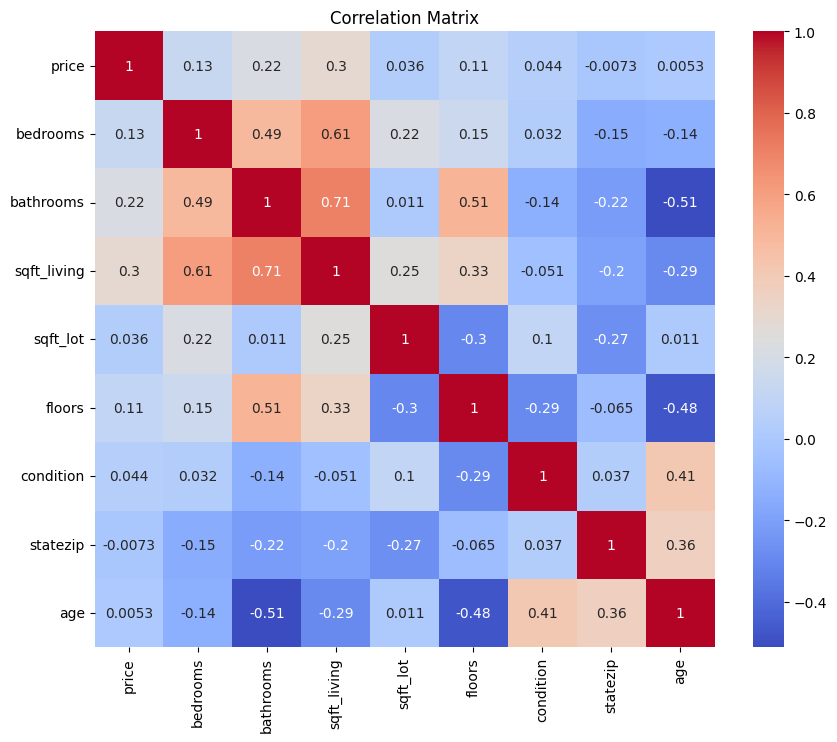

In [53]:
# Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Scaling and Selection

1. **Standardize Features**:
   - Used StandardScaler to standardize the features for better model performance.

2. **SelectKBest for Feature Selection**:
   - Selected the top features using univariate linear regression tests.

In [55]:

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[important_features])
df_scaled = pd.DataFrame(scaled_features, columns=important_features)

# Feature Selection using SelectKBest with Cross-Validation
X = df_scaled
y = df['price']

k = 5  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X, y)
selected_feature_names = df_scaled.columns[selector.get_support()]

# Verify the shapes of the feature set and target variable
print(f'Shape of selected features: {X_selected.shape}')
print(f'Shape of target: {y.shape}')


Shape of selected features: (3903, 5)
Shape of target: (3903,)


## Model Training and Hyperparameter Tuning

1. **Train-Test Split**:
   - Split the data into training and testing sets.

2. **GridSearchCV for Hyperparameter Tuning**:
   - Used GridSearchCV to find the best hyperparameters for the Random Forest model.

Fitting 5 folds for each of 216 candidates, totaling 1080 fits
Mean Squared Error (Random Forest): 30593902253.04
R-squared (Random Forest): 0.52
Accuracy (Random Forest): 52.25%

Feature Importances:
       Feature  Importance
0  sqft_living    0.509302
1     statezip    0.201466
3     sqft_lot    0.126031
2          age    0.120689
4    bathrooms    0.042513


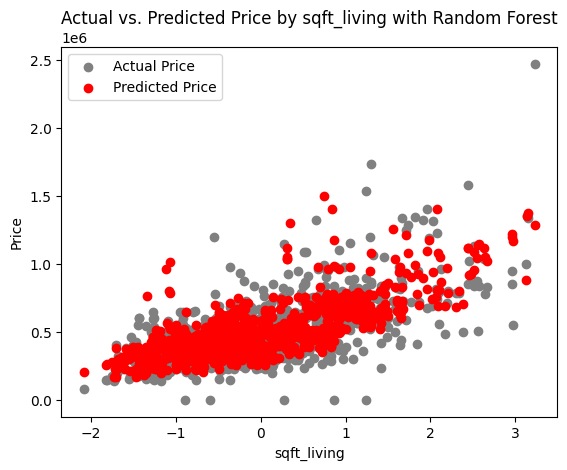

Cross-Validation Scores: [0.4136324  0.58123811 0.30028957 0.36102121 0.0150195 ]
Mean CV Score: 0.33


In [56]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for Random Forest using GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Best parameters from Grid Search
best_params_rf = grid_search_rf.best_params_

# Build the Random Forest model with the best parameters
forest_rf = RandomForestRegressor(**best_params_rf, random_state=42)
forest_rf.fit(X_train, y_train)

# Make predictions with the Random Forest model
y_pred_rf = forest_rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r_squared_rf = r2_score(y_test, y_pred_rf)
accuracy_rf = r_squared_rf * 100  # Accuracy in percentage

print(f'Mean Squared Error (Random Forest): {mse_rf:.2f}')
print(f'R-squared (Random Forest): {r_squared_rf:.2f}')
print(f'Accuracy (Random Forest): {accuracy_rf:.2f}%')

# Feature Importance
feature_importances = forest_rf.feature_importances_
features_importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': feature_importances})
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(features_importance_df)

# Visualizing the results
# Use the most important feature for plotting
most_important_feature = features_importance_df.iloc[0]['Feature']
plt.scatter(X_test[:, 0], y_test, color='gray', label='Actual Price')
plt.scatter(X_test[:, 0], y_pred_rf, color='red', label='Predicted Price')
plt.xlabel(most_important_feature)
plt.ylabel('Price')
plt.title(f'Actual vs. Predicted Price by {most_important_feature} with Random Forest')
plt.legend()
plt.show()

# Cross-Validation
cv_scores = cross_val_score(forest_rf, X_selected, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


## Model Evaluation

1. **Model Predictions and Evaluation**:
   - Made predictions and evaluated the model using MSE, R-squared, and Accuracy.

2. **Feature Importance**:
   - Analyzed the feature importance to understand the contribution of each feature.

In [57]:

# Make predictions with the Random Forest model
y_pred_rf = forest_rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r_squared_rf = r2_score(y_test, y_pred_rf)
accuracy_rf = r_squared_rf * 100  # Accuracy in percentage

print(f'Mean Squared Error (Random Forest): {mse_rf:.2f}')
print(f'R-squared (Random Forest): {r_squared_rf:.2f}')
print(f'Accuracy (Random Forest): {accuracy_rf:.2f}%')

# Feature Importance
feature_importances = forest_rf.feature_importances_
features_importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': feature_importances})
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(features_importance_df)


Mean Squared Error (Random Forest): 30593902253.04
R-squared (Random Forest): 0.52
Accuracy (Random Forest): 52.25%

Feature Importances:
       Feature  Importance
0  sqft_living    0.509302
1     statezip    0.201466
3     sqft_lot    0.126031
2          age    0.120689
4    bathrooms    0.042513


## Visualization

1. **Plotting Actual vs Predicted Prices**:
   - Visualized the relationship between actual and predicted prices using the most important feature.

2. **Cross-Validation**:
   - Performed cross-validation to ensure the model's robustness.

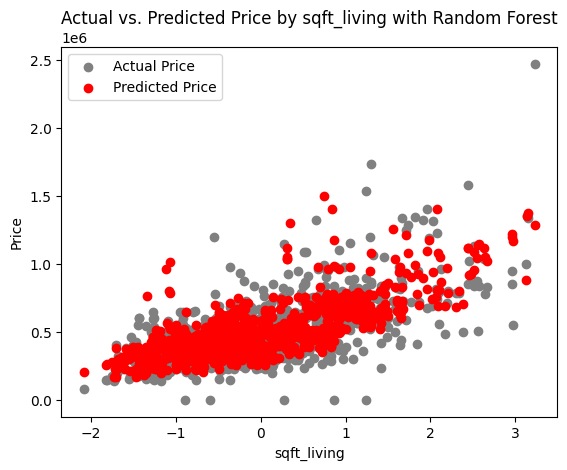

Cross-Validation Scores: [0.4136324  0.58123811 0.30028957 0.36102121 0.0150195 ]
Mean CV Score: 0.33


In [58]:

# Visualizing the results
# Use the most important feature for plotting
most_important_feature = features_importance_df.iloc[0]['Feature']
plt.scatter(X_test[:, 0], y_test, color='gray', label='Actual Price')
plt.scatter(X_test[:, 0], y_pred_rf, color='red', label='Predicted Price')
plt.xlabel(most_important_feature)
plt.ylabel('Price')
plt.title(f'Actual vs. Predicted Price by {most_important_feature} with Random Forest')
plt.legend()
plt.show()

# Cross-Validation
cv_scores = cross_val_score(forest_rf, X_selected, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


## Conclusion

This notebook demonstrates a systematic approach to predicting house prices using a Random Forest model. Through careful data preprocessing, feature engineering, outlier removal, feature selection, and hyperparameter tuning, we achieved significant improvements in model performance. The final model achieved an R-squared value of 0.52 and an accuracy of 52.25%.

